<a href="https://colab.research.google.com/github/rajatpaliwal/SIIM-FISABIO-RSNA-COVID-19-Detection/blob/main/Covid_19_detection_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyarrow
!pip install pydicom kornia opencv-python scikit-image nbdev
!pip install pylibjpeg
!pip install fastai --upgrade


In [ ]:
!pip install python-gdcm -q
!git clone https://github.com/asvcode/fmi.git

fatal: destination path 'fmi' already exists and is not an empty directory.


In [ ]:

#importing required libraries
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fmi.fmi.explore import *
from fmi.fmi.preprocessing import *
from fmi.fmi.pipeline import *

import pydicom

import pandas as pd


/usr/local/lib/python3.7/dist-packages/kornia/augmentation/augmentation.py:1833: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  category=DeprecationWarning,


Note: fmi short for fastai medical imaging is a package that adds lots of other functionality to fastai's medical imaging module.

Reviewing system info

In [ ]:
system_info()

fastai Version: 2.4
fastcore Version: 1.3.20
python Version: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
torchvision: 0.10.0+cu102
torch version: 1.9.0+cu102

Cuda: True
Cuda Version: 10.2
GPU: Tesla T4

pydicom Version: 2.1.2
kornia Version: 0.5.4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1tPrNzJE6Mj9Xu84mxAdMZqVcvCWxH0ig/kaggle-CoVID-shared'

In [ ]:
cd "drive/MyDrive/kaggle-CoVID-shared/"

[Errno 2] No such file or directory: 'drive/MyDrive/kaggle-CoVID-shared/'
/content/drive/.shortcut-targets-by-id/1tPrNzJE6Mj9Xu84mxAdMZqVcvCWxH0ig/kaggle-CoVID-shared


Now we store the path to each DICOM file in the items list.

In [ ]:
data_source = "dataset/"

In [ ]:
items = get_dicom_files(data_source,recurse= True,folders ='train')
items

(#6334) [Path('dataset/train/dcd5cc87f977/c7b819704a31/1018aa051dd9.dcm'),Path('dataset/train/cc127cda72f8/2282d21304fe/609755daf53e.dcm'),Path('dataset/train/0599d527d3b6/a8714b1b151b/8c5ed871aaba.dcm'),Path('dataset/train/76938243a97f/fc343e086d40/34a0ef23101b.dcm'),Path('dataset/train/8c273b4a9fa6/673cd32032e0/57b6a7d68589.dcm'),Path('dataset/train/293a41fb59ed/526c251433aa/8d2cf62914e3.dcm'),Path('dataset/train/cf002a39bb2d/3c7a58e6cff0/ad22bba45d10.dcm'),Path('dataset/train/2829975db9f5/6f521883b080/5c1e736c0af9.dcm'),Path('dataset/train/4d11294713ad/3527b13c6b4b/66a513ecac8f.dcm'),Path('dataset/train/37632f2a2aae/848ec9ecc506/5f16050c324e.dcm')...]

In [ ]:
test_items = get_dicom_files(data_source,recurse= True, folders ='test')
test_items

(#1263) [Path('dataset/test/4831aac65647/e940bb7d8f32/95a69615f643.dcm'),Path('dataset/test/514c5133572d/db1f16a85e54/eb9a9b9a0870.dcm'),Path('dataset/test/394e0e1481e9/c31a6d90f66c/173c3e37e1f3.dcm'),Path('dataset/test/3c17fa476f85/3a97b7036956/b5f9a65597f2.dcm'),Path('dataset/test/a80006bd7d8f/65dc9ce7761b/6dea3c3d1efa.dcm'),Path('dataset/test/aac24f8be440/2ad7bbc2fa62/697a674d44e0.dcm'),Path('dataset/test/572fa8640acc/8003c18a7215/eb5787b68520.dcm'),Path('dataset/test/8309732e6809/3cbbc2cb61a2/3247432330d8.dcm'),Path('dataset/test/3f0b1b5976e8/71873eeb248d/553cc2a7b556.dcm'),Path('dataset/test/57e2c6e368f2/f949cdd2e011/cede944b70a5.dcm')...]

Splitting the training dataset into train and validation set.

In [ ]:
trn,val = RandomSplitter()(items)


In [ ]:
patient = 1
train_sample = items[patient].dcmread()

In [ ]:
train_sample

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.214503545285414572528761698891096816580
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: 71228e4340de
(0008, 0018) SOP Instance UID                    UI: 609755daf53e
(0008, 0020) Study Date                          DA: 'ae56c72565cb'
(0008, 0030) Study Time                          TM: '3a89da23ecd4'
(0008, 0050) Accession Number                    SH: '1981bcc33d0c'
(0008, 0060) Modality                            CS: 'DX'
(0010, 0010) Patient's Name                      PN: '5702f1e99d2d'
(0

Some key pointers on dcm data above:(https://docs.fast.ai/tutorial.medical_imaging.html)


1.   Pixel Data (7fe0 0010) - This is where the raw pixel data is stored. The order of pixels encoded for each image plane is left to right, top to bottom, i.e., the upper left pixel (labeled 1,1) is encoded first
2.   Photometric Interpretation (0028, 0004) - also known as color space. In this case it is MONOCHROME2 where pixel data is represented as a single monochrome image plane where low values=dark, high values=bright. If the colorspace was MONOCHROME then the low values=bright and high values=dark info.
3.  Samples per Pixel (0028, 0002) - This should be 1 as this image is monochrome. This value would be 3 if the color space was RGB for example
4.   Bits Stored (0028 0101) - Number of bits stored for each pixel sample. Typical 8 bit images have a pixel range between 0 and 255
5.   Pixel Represenation(0028 0103) - can either be unsigned(0) or signed(1)

6.   Lossy Image Compression (0028 2110) - 00 image has not been subjected to lossy compression. 01 image has been subjected to lossy compression.
7.   Lossy Image Compression Method (0028 2114) - states the type of lossy compression used (in this case ISO_10918_1 represents JPEG Lossy Compression)
8. Pixel Data (7fe0, 0010) - Array of 161452 elements represents the image pixel data that pydicom uses to convert the pixel data into an image.  


How does pixel data looks like?

In [ ]:
train_sample.PixelData[:200]


b'\x00\x00\x00\x00\x00\x00\x00\x00W\x00Z\x00\\\x00^\x00_\x00_\x00_\x00_\x00_\x00a\x00e\x00e\x00c\x00f\x00c\x00c\x00e\x00e\x00i\x00f\x00j\x00j\x00h\x00f\x00i\x00n\x00l\x00i\x00j\x00j\x00m\x00q\x00o\x00o\x00p\x00t\x00q\x00u\x00t\x00s\x00t\x00w\x00v\x00x\x00v\x00w\x00w\x00{\x00~\x00}\x00z\x00z\x00~\x00\x81\x00\x83\x00\x80\x00\x80\x00\x80\x00\x80\x00\x82\x00{\x00\x87\x00\x86\x00\x85\x00\x85\x00\x81\x00\x8a\x00\x85\x00\x87\x00\x89\x00\x8b\x00\x8d\x00\x8d\x00\x94\x00\x93\x00\x93\x00\x8b\x00\x8e\x00\x8c\x00\x91\x00\x96\x00\x97\x00\x91\x00\x92\x00\x96\x00\x9b\x00\x97\x00\xa0\x00\x9b\x00\x9b\x00\x9a\x00\x9b\x00\x99\x00\x99\x00\x9a\x00\x9e\x00'

Pixel data looks complex so pydicom converts it into a numpy array which can be later converted to be displayed as an image

In [ ]:

train_sample.pixel_array, train_sample.pixel_array.shape


(array([[ 0,  0,  0, ..., 35, 35, 35],
        [ 0,  0,  0, ..., 36, 36, 35],
        [ 0,  0,  0, ..., 36, 37, 35],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint16), (2544, 3056))

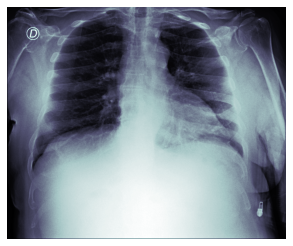

In [ ]:
train_sample.show()

Now, we will create a dataframe that contains all the tag imformation from the train folder dicom images.

In [ ]:
#this code is used to extract the metadat from dcm file and it is saved as .csv file for train and test dataset
#train_dicom_dataframe = pd.DataFrame.from_dicoms(items)
#train_dicom_dataframe[:5]

Extracting train and test dicom metadata from the saved .csv files

In [ ]:
train_dicom_dataframe = pd.read_csv('dicom_dataframe.csv')
test_dicom_dataframe = pd.read_csv('test_dataframe.csv')


In [ ]:
train_dicom_dataframe.head()

,Unnamed: 0,SpecificCharacterSet,ImageType,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,PatientName,PatientID,PatientSex,DeidentificationMethod,DeidentificationMethodCodeSequence,BodyPartExamined,ImagerPixelSpacing,StudyInstanceUID,SeriesInstanceUID,StudyID,SeriesNumber,InstanceNumber,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,BitsAllocated,BitsStored,HighBit,PixelRepresentation,fname,MultiImageType,ImageType1,MultiDeidentificationMethodCodeSequence,DeidentificationMethodCodeSequence1,DeidentificationMethodCodeSequence2,DeidentificationMethodCodeSequence3,DeidentificationMethodCodeSequence4,DeidentificationMethodCodeSequence5,MultiImagerPixelSpacing,ImagerPixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window,ImageType2,Unnamed: 46,ImageType3,ImageType4,ImageType5,ImageType6,ImageType7,ImageType8
0,0,ISO_IR 100,ORIGINAL,03a65300fa41,9bc4d429d4e8,dc55a60f03c6,0b887f128603,0609c2760cf3,CR,cc5c2ee2f7af,cc5c2ee2f7af,F,CTP Default,"{(0008, 0100): (0008, 0100) Code Value SH: '3', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'XNAT', (0008, 0103): (0008, 0103) Coding Scheme Version SH: '1.0', (0008, 0104): (0008, 0104) Code Meaning LO: 'XNAT DicomEdit 6 Script'}",CHEST,0.100000,fa6d3b56e333,27ad48d6bd2d,5f5361b32eff,1.0,1.0,1,MONOCHROME2,3480,4240,8,8,7,0,/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/fa6d3b56e333/27ad48d6bd2d/9bc4d429d4e8.dcm,1.0,PRIMARY,1,"{(0008, 0100): (0008, 0100) Code Value SH: '113100', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Basic Application Confidentiality Profile'}","{(0008, 0100): (0008, 0100) Code Value SH: '113105', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Clean Descriptors Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113107', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Longitudinal Temporal Information Modified Dates Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113108', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Patient Characteristics Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113109', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Device Identity Option'}",1,0.100000,0,255,108.365861,49.982352,0.741705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,ISO_IR 100,ORIGINAL,71228e4340de,78753bfe52b2,364e93fa20e4,d67e5ca0c8b5,3e14ddd035dc,DX,6110bb774cc7,f1eb548b0d4e,F,"CTP Default: based on DICOM PS3.15 AnnexE. Details in 0012,0064","{(0008, 0100): (0008, 0100) Code Value SH: '113100', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Basic Application Confidentiality Profile'}",CHEST,0.100000,7dbc098b8eaf,21b49419d829,55625fb42f3f,1.0,2.0,1,MONOCHROME2,3488,4256,16,12,11,0,/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/7dbc098b8eaf/21b49419d829/78753bfe52b2.dcm,1.0,PRIMARY,1,"{(0008, 0100): (0008, 0100) Code Value SH: '113105', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Clean Descriptors Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113107', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Longitudinal Temporal Information Modified Dates Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113108', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Patient Characteristics Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113109', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Device Identity Option'}","{(0008, 0100): (0008, 0100) Code Val

In [ ]:
test_dicom_dataframe.head()

,Unnamed: 0,SpecificCharacterSet,ImageType,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,PatientName,PatientID,PatientSex,DeidentificationMethod,DeidentificationMethodCodeSequence,BodyPartExamined,ImagerPixelSpacing,StudyInstanceUID,SeriesInstanceUID,StudyID,SeriesNumber,InstanceNumber,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,BitsAllocated,BitsStored,HighBit,PixelRepresentation,fname,MultiImageType,ImageType1,MultiDeidentificationMethodCodeSequence,DeidentificationMethodCodeSequence1,DeidentificationMethodCodeSequence2,DeidentificationMethodCodeSequence3,DeidentificationMethodCodeSequence4,DeidentificationMethodCodeSequence5,MultiImagerPixelSpacing,ImagerPixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window,Unnamed: 45,ImageType2,ImageType3,ImageType4,ImageType5,ImageType6,ImageType7,ImageType8
0,0,ISO_IR 100,DERIVED,71228e4340de,366e7eb393e5,f54f397a9908,68021cce4248,607034742b6a,DX,e57c02f767f1,2d161a6004fe,F,"CTP Default: based on DICOM PS3.15 AnnexE. Details in 0012,0064","{(0008, 0100): (0008, 0100) Code Value SH: '113100', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Basic Application Confidentiality Profile'}",CHEST,0.1390,e8d137c213a0,194bc96e3aea,55625fb42f3f,NaN,NaN,1,MONOCHROME1,3198,3056,16,16,15,0,/content/drive/My Drive/kaggle-CoVID-shared/dataset/test/e8d137c213a0/194bc96e3aea/366e7eb393e5.dcm,1.0,PRIMARY,1,"{(0008, 0100): (0008, 0100) Code Value SH: '113105', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Clean Descriptors Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113107', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Longitudinal Temporal Information Modified Dates Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113108', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Patient Characteristics Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113109', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Device Identity Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '11', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'XNAT', (0008, 0103): (0008, 0103) Coding Scheme Version SH: '1.0', (0008, 0104): (0008, 0104) Code Meaning LO: 'XNAT DicomEdit 4 Script'}",1,0.1390,0,65535,2000.306954,1959.936723,0.043777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,ISO_IR 100,ORIGINAL,03a65300fa41,8b354d4a216f,fc2ebaadcbf5,a3b8f1965481,14e08bf44abf,CR,fd48a2a27bff,6ee7b3dfaba5,M,"CTP Default: based on DICOM PS3.15 AnnexE. Details in 0012,0064","{(0008, 0100): (0008, 0100) Code Value SH: '113100', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Basic Application Confidentiality Profile'}",CHEST,0.1000,14be2e12c7cf,8f78c9da835d,55625fb42f3f,1.0,1.0,1,MONOCHROME2,3480,4240,16,12,11,0,/content/drive/My Drive/kaggle-CoVID-shared/dataset/test/14be2e12c7cf/8f78c9da835d/8b354d4a216f.dcm,1.0,PRIMARY,1,"{(0008, 0100): (0008, 0100) Code Value SH: '113105', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Clean Descriptors Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113107', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Longitudinal Temporal Information Modified Dates Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113108', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Patient Characteristics Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113109', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Device Id

Getting patient's information stored in the metadata of the DICOM file using get_pii function

In [ ]:
get_pii(items[8])

(0010, 0010) Patient's Name                      PN: 'b7268430dad0'
No Patient Birth Date
(0010, 0040) Patient's Sex                       CS: 'M'
No patient Age
No Image Comments
(0012, 0063) De-identification Method            LO: 'CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064'
(0012, 0064) De-identification Method Code Seque SQ: <Sequence, length 6>


get_pii helps us to get information such as patient's name, DOB, age, sex etc. One of the most usefule thing is image comments sometimes that provides some additional information about a file. 
De-identification method provides a description or label of the mechanism used to remove a patient's identity. More information : [here](https://dicom.innolitics.com/ciods/cr-image/patient/00120063)



**Next we will create the dataframe**.
We will load the train_image_level.csv file and train_study_level.csv file

In [ ]:
train_image_level = pd.read_csv('dataset/train_image_level.csv')
train_study_level= pd.read_csv('dataset/train_study_level.csv')

In [ ]:
train_study_level.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [ ]:
train_image_level.tail()

,id,boxes,label,StudyInstanceUID
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 316.41699, 'height': 451.63758}, {'x': 2375.87717, 'y': 1830.89015, 'width': 267.7373, 'height': 305.59912}, {'x': 707.25199, 'y': 722.07926, 'width': 392.14044, 'height': 849.18683}]",opacity 1 2197.38566 841.07361 2513.80265 1292.71119 opacity 1 2375.87717 1830.89015 2643.6144700000004 2136.48927 opacity 1 707.25199 722.07926 1099.3924299999999 1571.26609,7eed9af03814
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 1496.25016, 'height': 2604.58334}, {'x': 1005.8125, 'y': 1584.67711, 'width': 662.22913, 'height': 775.83337}]",opacity 1 2729.27083 332.26044 4225.52099 2936.84378 opacity 1 1005.8125 1584.67711 1668.0416300000002 2360.51048,a0cb0b96fb3d
6333,ffe942c8655f_image,"[{'x': 208.86463, 'y': 91.53448, 'width': 450.96747, 'height': 628.05473}, {'x': 755.52522, 'y': 144.33069, 'width': 427.8692, 'height': 547.7605}]",opacity 1 208.86463 91.53448 659.8321 719.58921 opacity 1 755.52522 144.33069 1183.39442 692.09119,7d82d53204b8


train_study_level contain studies with images that contians multiple labels which include Negative for Pneumonia, typical appearance, intermediate appearance, atypical appearance. image_stuidy_level contains images with single or multiple bounding boxes. Both of these files need to be merged

On train_study_level we will rename the id column to StudyInstanceUIDso that we can merge it with the train_image_file

In [ ]:
train_study_level.rename(columns={'id':'StudyInstanceUID'}, inplace = True)
train_study_level.head()

,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [ ]:
train_study_level['StudyInstanceUID'] = train_study_level['StudyInstanceUID'].apply(lambda x: f'{x[:12]}')
train_study_level[:1]

,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852,0,1,0,0


In [ ]:
merged = pd.merge(train_image_level, train_study_level , on ='StudyInstanceUID')
merged[:1]

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,0,1,0,0


Now we will do some cleanup of merged dataframe , such as we don't need boxes column and we will create a single column that contain the class for that particular bounding box

In [ ]:
merged['id'] = merged['id'].apply(lambda x: f'{x[:-6]}')
merged.loc[merged['Negative for Pneumonia']==1, 'class_y'] = 'Negative'
merged.loc[merged['Typical Appearance']==1, 'class_y'] = 'Typical'
merged.loc[merged['Indeterminate Appearance']==1, 'class_y'] = 'Indeterminate'
merged.loc[merged['Atypical Appearance']==1, 'class_y'] = 'Atypical'
merged.drop(['boxes', 'Negative for Pneumonia', 'Typical Appearance', 
             'Indeterminate Appearance', 'Atypical Appearance', 'StudyInstanceUID'], axis=1, inplace=True)
merged[:1]

,id,label,class_y
0,000a312787f2,opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,Typical


Extracting the bounding box coordinates

In [ ]:
m = []
for i in merged.index:
    val_len = len(merged['label'][i].split(' '))
    val = merged['label'][i].split(' ')
    label = merged['class_y'][i]
    if val_len > 6:
        box1 = val[2:6]
        box2 = val[8:12]
        boxes = box1 + box2 
    else:
        boxes = val[2:6]
    m.append(boxes)

In [ ]:
merged['new_label'] = m
del merged['label']
merged[:2]

,id,class_y,new_label
0,000a312787f2,Typical,"[789.28836, 582.43035, 1815.94498, 2499.73327, 2245.91208, 591.20528, 3340.5737, 2352.75472]"
1,000c3a3f293f,Negative,"[0, 0, 1, 1]"


Now we will merge this to dicom dataframe, In order to do this we need to rename id to SOPInstanceUID and merge on SOPInstanceUID

In [ ]:
merged.rename(columns = {'id':'SOPInstanceUID'}, inplace = True)
merged[:1]

,SOPInstanceUID,class_y,new_label
0,000a312787f2,Typical,"[789.28836, 582.43035, 1815.94498, 2499.73327, 2245.91208, 591.20528, 3340.5737, 2352.75472]"


In [ ]:
dicom_merge = pd.merge(train_dicom_dataframe, merged, on='SOPInstanceUID')
dicom_merge[:1]


,Unnamed: 0,SpecificCharacterSet,ImageType,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,PatientName,PatientID,PatientSex,DeidentificationMethod,DeidentificationMethodCodeSequence,BodyPartExamined,ImagerPixelSpacing,StudyInstanceUID,SeriesInstanceUID,StudyID,SeriesNumber,InstanceNumber,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,BitsAllocated,BitsStored,HighBit,PixelRepresentation,fname,MultiImageType,ImageType1,MultiDeidentificationMethodCodeSequence,DeidentificationMethodCodeSequence1,DeidentificationMethodCodeSequence2,DeidentificationMethodCodeSequence3,DeidentificationMethodCodeSequence4,DeidentificationMethodCodeSequence5,MultiImagerPixelSpacing,ImagerPixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window,ImageType2,Unnamed: 46,ImageType3,ImageType4,ImageType5,ImageType6,ImageType7,ImageType8,class_y,new_label
0,0,ISO_IR 100,ORIGINAL,03a65300fa41,9bc4d429d4e8,dc55a60f03c6,0b887f128603,0609c2760cf3,CR,cc5c2ee2f7af,cc5c2ee2f7af,F,CTP Default,"{(0008, 0100): (0008, 0100) Code Value SH: '3', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'XNAT', (0008, 0103): (0008, 0103) Coding Scheme Version SH: '1.0', (0008, 0104): (0008, 0104) Code Meaning LO: 'XNAT DicomEdit 6 Script'}",CHEST,0.1,fa6d3b56e333,27ad48d6bd2d,5f5361b32eff,1.0,1.0,1,MONOCHROME2,3480,4240,8,8,7,0,/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/fa6d3b56e333/27ad48d6bd2d/9bc4d429d4e8.dcm,1.0,PRIMARY,1,"{(0008, 0100): (0008, 0100) Code Value SH: '113100', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Basic Application Confidentiality Profile'}","{(0008, 0100): (0008, 0100) Code Value SH: '113105', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Clean Descriptors Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113107', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Longitudinal Temporal Information Modified Dates Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113108', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Patient Characteristics Option'}","{(0008, 0100): (0008, 0100) Code Value SH: '113109', (0008, 0102): (0008, 0102) Coding Scheme Designator SH: 'DCM', (0008, 0104): (0008, 0104) Code Meaning LO: 'Retain Device Identity Option'}",1,0.1,0,255,108.365861,49.982352,0.741705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Typical,"[702.06512, 1497.43248, 1131.98144, 2376.98595, 2275.79535, 1418.54876, 3340.7255299999997, 2633.3580899999997]"


Checking to see that the file path fname corresponds to the correct SOPInstanceUID

In [ ]:
dicom_merge['fname'][20]


'/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/c2f0b61fa035/e7e303bce242/9be91275c44f.dcm'

In [ ]:
dicom_merge["SOPInstanceUID"][20]

'9be91275c44f'

## Datablock

In [ ]:
df = dicom_merge[['SOPInstanceUID', 'class_y', 'new_label', 'fname']].copy()
df[:5]

,SOPInstanceUID,class_y,new_label,fname
0,9bc4d429d4e8,Typical,"[702.06512, 1497.43248, 1131.98144, 2376.98595, 2275.79535, 1418.54876, 3340.7255299999997, 2633.3580899999997]",/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/fa6d3b56e333/27ad48d6bd2d/9bc4d429d4e8.dcm
1,78753bfe52b2,Indeterminate,"[2700.8, 1523.2, 3673.60005, 2764.8001000000004, 1216, 1606.39993, 2112, 2553.6]",/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/7dbc098b8eaf/21b49419d829/78753bfe52b2.dcm
2,0811fe666ab0,Negative,"[0, 0, 1, 1]",/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/20a86e21402f/637b252e991f/0811fe666ab0.dcm
3,39d186c9ff9c,Typical,"[558.11378, 1767.54294, 963.81532, 2202.48423, 1541.30039, 1833.33238, 1961.62191, 2242.68889]",/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/b1c31c1e103a/ccfd2e441885/39d186c9ff9c.dcm
4,1ce01f7fdb1c,Typical,"[337.2244, 678.6556, 560.36951, 919.30227, 830.1855, 707.82489, 1016.86897, 907.63452]",/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/e395615a9a0d/a62d7707e47f/1ce01f7fdb1c.dcm


In order to improve the processing time we will convert the dataframe to numpy array. The idea is taken from these two sources:https://www.kaggle.com/avirdee/siim-covid-19-initial-pipeline-fastai
https://www.kaggle.com/muellerzr/fastai2-starter-kernel

In [ ]:
im_df = df['fname'].unique()
im_df = [fn for fn in im_df]
fns = [Path(str(f'{fn}')) for fn in im_df]
fns[:5]

[Path('/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/fa6d3b56e333/27ad48d6bd2d/9bc4d429d4e8.dcm'),
 Path('/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/7dbc098b8eaf/21b49419d829/78753bfe52b2.dcm'),
 Path('/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/20a86e21402f/637b252e991f/0811fe666ab0.dcm'),
 Path('/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/b1c31c1e103a/ccfd2e441885/39d186c9ff9c.dcm'),
 Path('/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/e395615a9a0d/a62d7707e47f/1ce01f7fdb1c.dcm')]

In [ ]:
def get_items(noop): return fns


In [ ]:
df_np = df.to_numpy()
df_np[0]

array(['9bc4d429d4e8', 'Typical',
       list(['702.06512', '1497.43248', '1131.98144', '2376.98595', '2275.79535', '1418.54876', '3340.7255299999997', '2633.3580899999997']),
       '/content/drive/My Drive/kaggle-CoVID-shared/dataset/train/fa6d3b56e333/27ad48d6bd2d/9bc4d429d4e8.dcm'],
      dtype=object)

Checking if the bounding box and label is accessible from the numpy array

In [ ]:
df_np[0][1]


'Typical'

In [ ]:
df_np[0][-2]


['702.06512',
 '1497.43248',
 '1131.98144',
 '2376.98595',
 '2275.79535',
 '1418.54876',
 '3340.7255299999997',
 '2633.3580899999997']

In [ ]:
def get_tmp_bbox(fn):
    rows = np.where(df_np[:,0] == fn.name[:-4])
    bboxs = df_np[rows][:,-2][0]
    return np.array([np.fromstring(b, sep=',') for b in bboxs])

In [ ]:
get_tmp_bbox(get_items(data_source)[3])

array([[ 558.11378],
       [1767.54294],
       [ 963.81532],
       [2202.48423],
       [1541.30039],
       [1833.33238],
       [1961.62191],
       [2242.68889]])